**TASK**: Forecasting bus demand in Banana Republic municipalities.

To forecast the hourly bus usage for next week, I followed these steps;

1. Load and preprocess the dataset: After loading the dataset, I grouped the data by municipality and time to get the maximum bus usage for each hour.
2. Data exploration: I plotted the data for each municipality.
3. Baseline model: I built and tested a simple model to predict data for the last two weeks.
4. Evaluation: I evaluated the performance of the model.

### Examining and Manipulating the Dataset

In [1]:
# required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm


import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings(action = "ignore", category = UserWarning)


# Load the dataset
url = 'https://pi.works/3w8IJbV'
bus_demand = pd.read_csv(url)
df = bus_demand.copy()

df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [2]:
df.isnull().sum() # any nan values?

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [3]:
df[df.duplicated()] # any duplicated?

,timestamp,municipality_id,usage,total_capacity


In [4]:
df.info() # the dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [5]:
# converting steps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['municipality_id'] = df['municipality_id'].astype(str)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  object        
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 408.6+ KB


In [7]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2017-06-04 07:59:42'), Timestamp('2017-08-19 16:30:35'))

In [8]:
# describe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


In [9]:
# extract hour from the timestamp column to create an time_hour column
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  object        
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
 4   hour             13070 non-null  int64         
 5   date             13070 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 612.8+ KB


In [12]:
df.head()

,timestamp,municipality_id,usage,total_capacity,hour,date
0,2017-06-04 07:59:42,9,454,1332,7,2017-06-04
1,2017-06-04 07:59:42,8,556,2947,7,2017-06-04
2,2017-06-04 07:59:42,4,1090,3893,7,2017-06-04
3,2017-06-04 07:59:42,0,204,2813,7,2017-06-04
4,2017-06-04 07:59:42,7,718,2019,7,2017-06-04


In [13]:
df = df.groupby(["municipality_id","date", "hour"])[["usage"]].max().reset_index()

In [14]:
df.head(10)

,municipality_id,date,hour,usage
0,0,2017-06-04,7,204
1,0,2017-06-04,8,332
2,0,2017-06-04,9,485
3,0,2017-06-04,10,583
4,0,2017-06-04,11,614
5,0,2017-06-04,12,613
6,0,2017-06-04,13,605
7,0,2017-06-04,14,585
8,0,2017-06-04,15,520
9,0,2017-06-04,16,470


In [15]:
df.tail()

,municipality_id,date,hour,usage
6735,9,2017-08-19,12,849
6736,9,2017-08-19,13,941
6737,9,2017-08-19,14,983
6738,9,2017-08-19,15,976
6739,9,2017-08-19,16,879


In [16]:
df.groupby(['municipality_id'])[['hour','usage']].max()

,hour,usage
municipality_id,,
0,16,1543
1,16,412
2,16,697
3,16,1646
4,16,3508
5,16,582
6,16,1920
7,16,1923
8,16,1476


In [17]:
df.hour.value_counts().sort_index()

7     260
8     720
9     720
10    720
11    720
12    720
13    720
14    720
15    720
16    720
Name: hour, dtype: int64

### Visualization

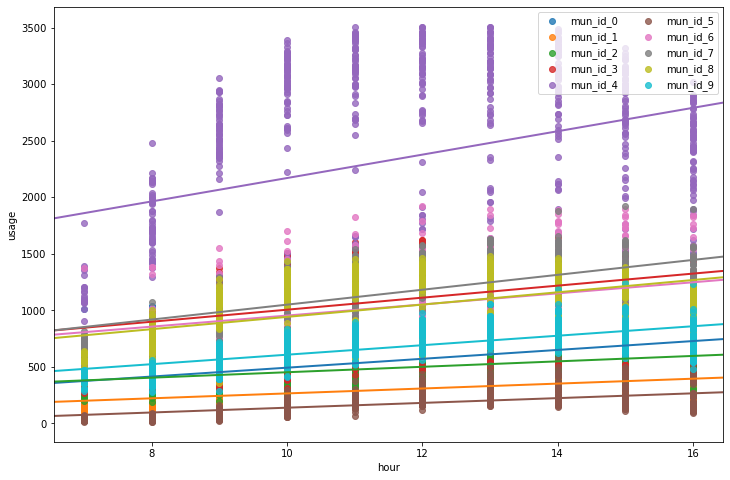

In [18]:
np.random.seed(123)
fig, ax = plt.subplots(figsize = (12, 8))
mun_ids = []

for i in range(10):
    mun_ids.append('mun_id_' + str(i))
    mun_id = df.loc[df['municipality_id'] == str(i)]
    sns.regplot(x = 'hour', y = 'usage', data = mun_id,
                ci = None,
                ax = ax,
                line_kws = {'lw': 2},
                scatter = True, truncate=False, label = mun_ids[i])
plt.legend(fontsize = 10, ncol = 2, loc = 'upper right')
plt.show();

In [19]:
# sns.lmplot(data = df, x = 'hour', y = 'usage', hue = 'municipality_id', scatter_kws={'s': 22});

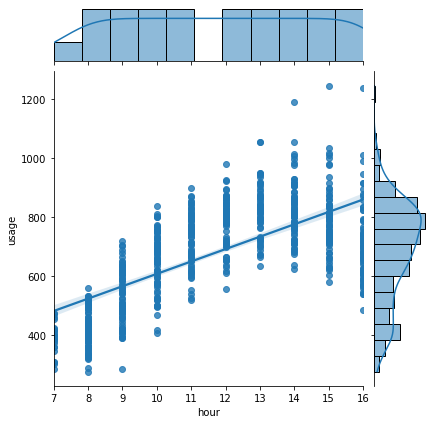

In [20]:
mun_id_7 = df.loc[df['municipality_id'] == str(7)]
sns.jointplot(x = 'hour', y = 'usage', data = mun_id, kind = 'reg');

In [21]:
df.corr()

,hour,usage
hour,1.000000,0.186771
usage,0.186771,1.000000


### Modeling and Prediction

In [22]:
df.head()

,municipality_id,date,hour,usage
0,0,2017-06-04,7,204
1,0,2017-06-04,8,332
2,0,2017-06-04,9,485
3,0,2017-06-04,10,583
4,0,2017-06-04,11,614


In [23]:
# Split the dataset into training and test sets
train = df[df['date'] < '2017-08-05']
test = df[df['date'] >= '2017-08-05']

#### Model: Statsmodels (Basic)

* statsmodels is used because there is a linear relationship between 'hour' and 'stage'

In [24]:
# independent variable: hour, dependent variable: usage

for i in range(10):
    mun_id = train.loc[train['municipality_id'] == str(i)]
    X = mun_id[["hour"]]
    X = sm.add_constant(X) # coefficient
    y = mun_id["usage"]

    # model nesnesinin olusturulması ve fit edilmesi
    lm = sm.OLS(y, X)
    model = lm.fit()
    
    # hata degerleri
    mse = np.mean((y - model.fittedvalues) ** 2) # MSE
    rmse = np.sqrt(mse) # RMSE
    rscore = model.rsquared # r-squared
    pvalue = model.f_pvalue # p-value

    print(f"\n ******************* For Municipality Id: {i} ******************* ")
    print("Significance of the model (significant if p-value < 0.05): ", pvalue)
    print("Success percentage of the model (r-squared): ", rscore * 100)
    print("The mean squared error of the model (MSE): ", mse)
    print("Error value of the model (RMSE): ", rmse)



 ******************* For Municipality Id: 0 ******************* 
Significance of the model (significant if p-value < 0.05):  3.021347538043923e-36
Success percentage of the model (r-squared):  25.80532552180047
The mean squared error of the model (MSE):  36801.95836586913
Error value of the model (RMSE):  191.8383652084982

 ******************* For Municipality Id: 1 ******************* 
Significance of the model (significant if p-value < 0.05):  8.99226835960854e-68
Success percentage of the model (r-squared):  43.52852897889099
The mean squared error of the model (MSE):  4340.602729575696
Error value of the model (RMSE):  65.8832507514292

 ******************* For Municipality Id: 2 ******************* 
Significance of the model (significant if p-value < 0.05):  4.467862918166972e-36
Success percentage of the model (r-squared):  25.69629959734695
The mean squared error of the model (MSE):  10742.543121998953
Error value of the model (RMSE):  103.64624026948084

 ******************* 

In [25]:
print(model.summary()) # model summary for last one (mun_id = 9)

                            OLS Regression Results                            
Dep. Variable:                  usage   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     393.0
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           7.49e-66
Time:                        02:06:51   Log-Likelihood:                -3321.5
No. Observations:                 532   AIC:                             6647.
Df Residuals:                     530   BIC:                             6656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        201.2910     24.293      8.286      0.0

In [26]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,201.2910,24.293,8.286,0.000,153.569,249.013
hour,39.7175,2.003,19.825,0.000,35.782,43.653


In [27]:
# forecasting for municipality_id 9
mun_id_pred = test.loc[test['municipality_id'] == str(9)]
pred_9 = mun_id_pred['hour']
pred_9 = sm.add_constant(pred_9)

pred_9.head()

,const,hour
6598,1.0,8
6599,1.0,9
6600,1.0,10
6601,1.0,11
6602,1.0,12


In [28]:
model.predict(pred_9)[0:10]

6598    519.030778
6599    558.748253
6600    598.465727
6601    638.183202
6602    677.900677
6603    717.618152
6604    757.335626
6605    797.053101
6606    836.770576
6607    479.313303
dtype: float64

In [29]:
mun_id_9 = test.loc[test['municipality_id'] == str(9)]
mun_id_9['forecasting_usage'] = model.predict(pred_9).values.astype(int)

mun_id_9.head(10)

<ipython-input-29-379fe8615e9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mun_id_9['forecasting_usage'] = model.predict(pred_9).values.astype(int)


,municipality_id,date,hour,usage,forecasting_usage
6598,9,2017-08-05,8,333,519
6599,9,2017-08-05,9,424,558
6600,9,2017-08-05,10,564,598
6601,9,2017-08-05,11,761,638
6602,9,2017-08-05,12,799,677
6603,9,2017-08-05,13,826,717
6604,9,2017-08-05,14,803,757
6605,9,2017-08-05,15,711,797
6606,9,2017-08-05,16,620,836
6607,9,2017-08-06,7,386,479
